#### Import libraries

In [6]:
import sys
sys.path.append('BEHRT/Early_integration/')
sys.path.append('BEHRT/')

import pandas as pd
from torch.utils.data import Dataset, DataLoader, Sampler
import os
import torch
import torch.nn as nn
import pytorch_pretrained_bert as Bert
import sklearn

from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray import tune

from Utils import optimiser
from Utils.common import create_folder
import sklearn.metrics as skm
import math
from torch.utils.data.dataset import Dataset
import random
import numpy as np
import time
from Utils.utils import age_vocab, input_vocab, mod_vocab, delay_vocab
from sklearn.metrics import roc_auc_score
from Utils.dataLoader_utils import ImbSampler, OverSampler, StratifiedSampler
from Utils.NextXVisit_v2 import NextVisit
from Models.BertForClassification import BertForClassification
from datetime import datetime
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import StratifiedKFold

#### ## ROC 
import sklearn.metrics as metrics
import seaborn as sns
## Plot results

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import seaborn as sn 
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings(action='ignore')

from Utils.add_endpoints import add_endp
from Utils.handle_file import handle_file

hf = handle_file()

2023-02-06 14:47:06.774350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Utils

In [7]:
def get_train_test_valid_idx(dataset):
    patient_idx = dataset.index
    
    train_idx = hf._load_pkl(file_config['train_idx'])
    train_idx = [idx for idx in train_idx if idx in patient_idx]

    test_idx = hf._load_pkl(file_config['test_idx'])
    test_idx = [idx for idx in test_idx if idx in patient_idx]

    valid_idx = hf._load_pkl(file_config['valid_idx'])
    valid_idx = [idx for idx in valid_idx if idx in patient_idx]
    
    return train_idx, test_idx, valid_idx

def split_data(dataset):
    train_idx, test_idx, valid_idx = get_train_test_valid_idx(dataset)
    
    
    train = dataset.loc[train_idx ,:]
    valid = dataset.loc[valid_idx ,:]
    test = dataset.loc[test_idx ,:]

    train = train.rename_axis('patid')
    valid = valid.rename_axis('patid')
    test = test.rename_axis('patid')

    train.reset_index(inplace=True)
    valid.reset_index(inplace=True)
    test.reset_index(inplace=True)

    train['patid'] = train['patid'].replace(train.patid.values,range(len(train.patid.values)))
    valid['patid'] = valid['patid'].replace(valid.patid.values,range(len(valid.patid.values)))
    test['patid'] = test['patid'].replace(test.patid.values,range(len(test.patid.values)))

    return train, test, valid 



#### Performing checks for the resources available 

In [ ]:
# Check if there is a gpu available 

if torch.cuda.is_available():
   
    device = torch.device("cuda")
    print("There are %d GPU(s) available. " %torch.cuda.device_count())
    print("We will use the GPU: {}".format(torch.cuda.get_device_name(0)))
    
else:
    print("No GPU available, using the CPU instead")
    device = torch.device("cpu")
    
""" Empty the cache to enable the use of the gpu """

def empty_cuda():
    torch.cuda.empty_cache()
    print(torch.cuda.memory_summary(device=None, abbreviated=False))


#### Run Binary Classification 
1. Config

In [11]:
## Embeddings used for the classification 

pretrain_model_path =  'BEHRT/Early_integration/Tasks/Output/MLM_mean.pkl'   # pretrained MLM path

file_config = { 'data':'BEHRT/Early_integration/Files/data_preprocessed_in_512_chunks_notherap_100.pkl',
                'labels' : 'BEHRT/Late_integration/Files/relapses.csv', 
                'train_idx' : 'BEHRT/Late_integration/Files/train_ids.pkl',
                'valid_idx' : 'BEHRT/Late_integration/Files/valid_ids.pkl',
                'test_idx' : 'BEHRT/Late_integration/Files/test_ids.pkl', 
                }

optim_config = {
    'lr': 5e-5,
    'warmup_proportion': 0.1,
    'weight_decay': 0.01
}

global_params = {
    'batch_size': 32,
    'gradient_accumulation_steps': 4,
    'device': device ,
    'output_dir': 'BEHRT/Early_integration/Tasks/Output', # output folder
    'best_name': 'CLF_model',  # output model name
    'max_len_seq': 512, #100,
    'max_age': 110,
    'max_delay': 30, ## = 30years
    'age_month': 12,
    'delay_month': 0.25,
    'age_year': False,
    'age_symbol': None,
    'min_visit': 2,
}

feature_dict = {
            'word':True,
            'seg':True,
            'age':True,
            'modalities': True,
            'delays': True,
            'position': True
                }

class BertConfig(Bert.modeling.BertConfig):
    def __init__(self, config):
        super(BertConfig, self).__init__(
            vocab_size_or_config_json_file=config.get('vocab_size'),
            hidden_size=config['hidden_size'],
            num_hidden_layers=config.get('num_hidden_layers'),
            num_attention_heads=config.get('num_attention_heads'),
            intermediate_size=config.get('intermediate_size'),
            hidden_act=config.get('hidden_act'),
            hidden_dropout_prob=config.get('hidden_dropout_prob'),
            attention_probs_dropout_prob=config.get('attention_probs_dropout_prob'),
            max_position_embeddings = config.get('max_position_embedding'),
            initializer_range=config.get('initializer_range'),
        )
        self.delays_vocab_size = config.get('delays_vocab_size')
        self.modalities_vocab_size = config.get('modalities_vocab_size')
        self.age_vocab_size = config.get('age_vocab_size')
        self.seg_vocab_size = config.get('seg_vocab_size')
        self.output_attentions = config.get('output_attentions')
        self.chunk_size_feed_forward = config.get('chunk_size_feed_forward')
        self.is_decoder = config.get('is_decoder')
        self.layer_norm_eps = config.get('layer_norm_eps')
        self.add_cross_attention = config.get('add_cross_attention')
        

2. Import data

In [12]:
"""Import train data """
data =  hf._load_pkl(file_config['data'])


"""Import labels """
labels = hf._load_csv(file_config['labels'])
labels.drop(['Unnamed: 0', 'status_drfs_5y'], axis='columns', inplace = True)
labels.rename(columns={'status_rfs_surg_5y': 'label'}, inplace=True)

"""Merge label and data """
data = pd.merge(data, labels, on=['Num_dossier'])
data.set_index('Num_dossier', inplace=True)

# Display 3 first rows
data.head(3)

AttributeError: Can't get attribute '_unpickle_block' on <module 'pandas._libs.internals' from '/Users/maguette/opt/anaconda3/lib/python3.7/site-packages/pandas/_libs/internals.cpython-37m-darwin.so'>

In [ ]:
# remove patients with visits less than min visit
previous_shape = data.shape[0]

data['length'] = data['inputs_quantiles_preprocessed_100_therap_removed_tolist'].apply(lambda x: len([i for i in range(len(x)) if x[i] == 'SEP']))
data = data[data['length'] >= global_params['min_visit']]
#data = data.reset_index(drop=True)

print("We lost {} patient".format(previous_shape - data.shape[0]))

In [ ]:
whole_seq = hf._load_pkl('/home/jovyan/work/Workdir/Secondment_1/Secondment 1/tasks/Early integration/BEHRT Final version/whole_seq_preprocessed.pkl')

tokenVocab, _ = input_vocab(inputs = data.inputs_normal_range_preprocessed_100_therap_removed, symbol=global_params['age_symbol'])
ageVocab, _ = age_vocab(max_age=global_params['max_age'], mon = global_params['age_month'], symbol=global_params['age_symbol'])
modalitiesVocab, _ = mod_vocab(data.modalities_100_therap_removed, symbol=global_params['age_symbol'])
delayVocab, _ = delay_vocab(max_delay=global_params['max_delay'], mon = global_params['delay_month'], symbol=global_params['age_symbol'])

# Binary classification 
labelVocab = {0:0, 1:1}

In [ ]:
model_config = {
    'vocab_size': len(tokenVocab), # number of disease + symbols for word embedding
    'hidden_size': 288, # word embedding and seg embedding hidden size
    'seg_vocab_size': 2, # number of vocab for seg embedding
    'modalities_vocab_size': len(modalitiesVocab), 
    'age_vocab_size': len(ageVocab), # number of vocab for age embedding
    'delays_vocab_size': len(delayVocab), 
    'max_position_embedding':global_params['max_len_seq'],  # maximum number of tokens
    'hidden_dropout_prob': 0.3, # dropout rate
    'num_hidden_layers': 6, # number of multi-head attention layers required
    'num_attention_heads': 12, # number of attention heads
    'attention_probs_dropout_prob': 0.2, # multi-head attention dropout rate
    'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
    'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
    'initializer_range': 0.02, # parameter weight initializer range
    'chunk_size_feed_forward' : 0,
    'use_return_dict': True,
    'output_attentions': True,
    'output_hidden_states':True,
    'is_decoder': False,
    'layer_norm_eps' : 1e-12,  #1e-5
    'add_cross_attention' : False
}

feature_dict = {
    'word':True,
    'seg':True,
    'age':True,
    'modalities': True,
    'delays': True,
    'position': True
}

3. Prepare data

In [ ]:
train, test, valid = split_data(data)

In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda:0' else {'num_workers': 5}


In [11]:
X_train = train['inputs_curve_intersections_preprocessed_100_therap_removed_tolist']
y_train = train['label']

Dset = NextVisit(token2idx=tokenVocab, label2idx=labelVocab, mod2idx=modalitiesVocab, age2idx=ageVocab, del2idx=delayVocab, dataframe=train, max_len=global_params['max_len_seq'],  code='inputs_curve_intersections_preprocessed_100_therap_removed_tolist', delay ='delays_100_therap_removed_into_chunks_tolist'
                              , age = "age_100_therap_removed_into_chunks_tolist", mod='modalities_100_therap_removed_into_chunks_tolist' )
hp_generator = {'batch_size': global_params['batch_size'], 'balanced': 'balanced', 'shuffle':True}
trainload = DataLoader(dataset=Dset, batch_size=global_params['batch_size'],  sampler = StratifiedSampler(X_train, y_train, batch_size=global_params['batch_size']) , **kwargs)


In [ ]:

Dset = NextVisit(token2idx=tokenVocab, label2idx=labelVocab, mod2idx=modalitiesVocab, age2idx=ageVocab, del2idx=delayVocab, dataframe=valid, max_len=global_params['max_len_seq'],  code='inputs_curve_intersections_preprocessed_100_therap_removed_tolist', delay ='delays_100_therap_removed_into_chunks_tolist'
                              , age = "age_100_therap_removed_into_chunks_tolist", mod='modalities_100_therap_removed_into_chunks_tolist' )
validload = DataLoader(dataset=Dset, batch_size=global_params['batch_size'],  shuffle = True, **kwargs)


In [ ]:
Dset = NextVisit(token2idx=tokenVocab, label2idx=labelVocab, mod2idx=modalitiesVocab, age2idx=ageVocab, del2idx=delayVocab, dataframe=test, max_len=global_params['max_len_seq'], code='inputs_curve_intersections_preprocessed_100_therap_removed_tolist', delay ='delays_100_therap_removed_into_chunks_tolist'
                              , age = "age_100_therap_removed_into_chunks_tolist", mod='modalities_100_therap_removed_into_chunks_tolist' )
testload = DataLoader(dataset=Dset, batch_size=global_params['batch_size'],  shuffle = False, **kwargs)


#### Model

1. Model settings

In [4]:
def load_model(path, model):
    # load pretrained model and update weights
    pretrained_dict = torch.load(path)
    model_dict = model.state_dict()
    
    # 1. filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict)
    
    # 3. load the new state dict
    model.load_state_dict(model_dict)
    return model

In [ ]:
def define_model(model_config):
    # del model
    
    class_weights = torch.tensor(config['class_weights'])
    conf = BertConfig(model_config)
    model = BertForClassification(conf, num_labels=len(labelVocab.keys()), feature_dict=feature_dict, class_weights = class_weights)
    model = load_model(pretrain_model_path, model)                          
    model = model.to(global_params['device'])
    optim = optimiser.adam(params=list(model.named_parameters()), config=model_config)
    
    return model, optim

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=list(labelVocab.values()))
mlb.fit([[each] for each in list(labelVocab.values())])

2. Scores

In [ ]:
def scoring_for_train(logits, label):
    sig = nn.Sigmoid()
    output = sig(logits)
    label, output = label.cpu(), output.detach().cpu()
    label = np.argmax(label, axis=1)
    output = np.argmax(output, axis=1)
    
    f1 =  sklearn.metrics.f1_score(label.numpy(), output.numpy(), average="macro")
    
    return f1, output, label

def scoring_for_valid(logits, label):
    sig = nn.Sigmoid()
    output = sig(logits)
    label = np.argmax(label, axis=1)
    output = np.argmax(output, axis=1)  
    
    f1 =  sklearn.metrics.f1_score(label.numpy(), output.numpy(), average="macro")
    roc = sklearn.metrics.roc_auc_score(label.numpy(),output.numpy(), average='samples')

    return f1, roc, output, label

def scoring_for_test(logits, label):
    sig = nn.Sigmoid()
    output = sig(logits)
    label = np.argmax(label, axis=1)
    output = np.argmax(output, axis=1)
    
    roc = sklearn.metrics.roc_auc_score(label.numpy(),output.numpy(), average='samples')
    f1 =  sklearn.metrics.f1_score(label.numpy(), output.numpy(), average="macro")
    recall = sklearn.metrics.recall_score(label.numpy(), output.numpy(), average="macro")
    precision = sklearn.metrics.precision_score(label.numpy(), output.numpy(), average="macro")
 
    return f1, roc, recall, precision, output, label

3. Utils

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    

4. Model development

In [22]:
training_stats = []
       
def training(e, train_dataloader, valid_dataloader):
    
    start = time.time()
    
    # Reset the loss at each epoch
    temp_loss, temp_f1 = [], []
    train_f1, train_loss = [], []
    nb_tr_examples, nb_tr_steps = 0, 0
    cnt = 0
    count = 0
    
    model.train()

    for step, batch in enumerate(train_dataloader):
        
        cnt +=1
        age_ids, input_ids, mod_ids, del_ids, posi_ids, segment_ids, attMask, targets, _ = batch
        targets = torch.tensor(mlb.transform(targets.numpy()), dtype=torch.float32)
    
        ## Load batch to gpu 
        age_ids = age_ids.to(global_params['device'])
        input_ids = input_ids.to(global_params['device'])
        mod_ids = mod_ids.to(global_params['device'])
        del_ids = del_ids.to(global_params['device'])
        posi_ids = posi_ids.to(global_params['device'])
        segment_ids = segment_ids.to(global_params['device'])
        attMask = attMask.to(global_params['device'])
        targets = targets.to(global_params['device'])
        
        
        ## Compute output (loss, logits and attentions scores) 
        output = model(input_ids, mod_ids, age_ids, del_ids, segment_ids, posi_ids,attention_mask=attMask, labels=targets, output_attentions = True)
  
        loss = output.loss
        logits  = output.logits
        attentions = output.attentions
        
        if global_params['gradient_accumulation_steps'] >1:
            loss = loss/global_params['gradient_accumulation_steps']
        
        loss.backward()
        

        temp_loss.append(loss.item())
        train_loss.append(loss.item())
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1
        
        f1, a, b = scoring_for_train(logits, targets)
       
        temp_f1.append(f1)
   
        # Progress update every 500 batches
        if step % 40 == 0:
            print("epoch: {}\t| Cnt: {}\t| Loss: {}\t| f1 score: {}".format(e, cnt, np.mean(temp_loss), np.mean(temp_f1)))
            temp_loss, temp_f1 = [], []
             
        
        if (step + 1) % global_params['gradient_accumulation_steps'] == 0:
  
            optim.step()
            optim.zero_grad()
            
        train_f1.append(f1)
        count+=1
 

        
    # Measure how long this epoch took.
    training_time = format_time(time.time() - start)
                   
    print("")
    print("Average training loss: {0:.2f}".format(np.mean(train_loss)))
    print("Average training score: {0:.2f}".format(np.mean(train_f1)))
    print("Training epoch took: {:}".format(training_time))
    
          
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")
    
    valid_f1, valid_roc, valid_loss, valid_time = evaluation(valid_dataloader)
    
    # Record all statistics from this epoch.
    training_stats.append({'epoch': e+1, 
                               'Training Loss': np.mean(train_loss) ,
                               'Training Time' : training_time,
                               'Average Train f1 score' : np.mean(train_f1),
                               'Validation Loss': np.mean(valid_loss), 
                               'Validating Time' : valid_time, 
                               'Average Valid f1 score' : np.mean(valid_f1),
                               'Average Valid ROC' : np.mean(valid_roc)
                                })  
        
    return valid_f1, train_f1, valid_loss, train_loss, valid_roc, training_stats
    

def evaluation(data):
                               
    start = time.time()
                               
    model.eval()
    y = []
    y_label = []
    val_loss, total_f1, total_roc = [], [], []
    val_loss_tot, tot_f1, tot_roc = [], [], []
    
    for step, batch in enumerate(data):
        
        age_ids, input_ids, mod_ids, del_ids, posi_ids, segment_ids, attMask, targets, _ = batch
        targets = torch.tensor(mlb.transform(targets.numpy()), dtype=torch.float32)
     
        
        age_ids = age_ids.to(global_params['device'])
        input_ids = input_ids.to(global_params['device'])
        mod_ids = mod_ids.to(global_params['device'])
        del_ids = del_ids.to(global_params['device'])
        posi_ids = posi_ids.to(global_params['device'])
        segment_ids = segment_ids.to(global_params['device'])
        attMask = attMask.to(global_params['device'])
        targets = targets.to(global_params['device'])
      
        with torch.no_grad():
            outputs = model(input_ids, mod_ids, age_ids, del_ids, segment_ids, posi_ids,attention_mask=attMask, labels=targets, output_attentions=True)
        
        val_loss.append(outputs.loss.item())
        
        logits = outputs.logits.cpu()
        targets = targets.cpu()
        
        y_label.append(targets)
        y.append(logits)
        

    y_label = torch.cat(y_label, dim=0)
    y = torch.cat(y, dim=0) 
    
    tot_f1, tot_roc, output, label = precision_valid(y, y_label)
   
    # Measure how long this epoch took.
    validation_time = format_time(time.time() - start)
    
    print("Validation Loss: {0:.2f}".format(np.mean(val_loss)))
    print("Validation took: {:}".format(validation_time))
    print()
    
    #output_path = 'BEHRT/Early_integration/Tasks/Output/binary_clf'
    #os.makedirs(output_path, exist_ok=True)
    #torch.save(model.state_dict(), optim.state_dict()), output_path+'/checkpoint.pt')
    #session.report({'loss':np.mean(val_loss), 'f1_score':np.mean(tot_f1)}, checkpoint=checkpoint)
    
    return tot_f1, tot_roc, val_loss, validation_time


In [24]:
def train_BEHRT(config, epochs=range(2), inputs='inputs_quantiles_preprocessed_100_therap_removed_tolist', age = "age_100_therap_removed_into_chunks_tolist", 
         modalities = 'modalities_100_therap_removed_into_chunks_tolist', delay ='delays_100_therap_removed_into_chunks_tolist'):
    
    set_seed()
    train_skf = pd.concat([train, valid])
    X_train_skf = train_skf['inputs_quantiles_preprocessed_100_therap_removed_tolist']
    y_train_skf = train_skf['label']
    
    n = 5
    skf = StratifiedKFold(n_splits = n)
    
    
    for i, (train_idx, cross_val_idx) in enumerate(skf.split(X_train_skf, y_train_skf)):
        train_df = train_skf.iloc[train_idx]
        train_df.index = range(train_df.shape[0])
        train_df.patid = range(train_df.shape[0])
        
        cv_df = train_skf.iloc[cross_val_idx]
        cv_df.index = range(cv_df.shape[0])
        cv_df.patid = range(cv_df.shape[0])
        
        ## Load train and valid data 
        
        X_tr = train_df[inputs]
        y_tr = train_df['label']
        
        Dset = NextVisit(token2idx=tokenVocab, label2idx=labelVocab, mod2idx=modalitiesVocab, age2idx=ageVocab, del2idx=delayVocab, dataframe=train_df, max_len=global_params['max_len_seq'], code= inputs, delay = delay, age = age, mod=modalities)
        hp_generator = {'batch_size': config['batch_size'], 'balanced': 'balanced', 'shuffle':True}
        train_data = DataLoader(dataset=Dset, batch_size=config['batch_size'],  sampler = StratifiedSampler(X_tr, y_tr, batch_size=config['batch_size']) , **kwargs)
        
        Dset = NextVisit(token2idx = tokenVocab, label2idx=labelVocab, mod2idx=modalitiesVocab, age2idx=ageVocab, del2idx=delayVocab, dataframe=cv_df, max_len=global_params['max_len_seq'], code= inputs, delay = delay, age = age, mod=modalities)
        valid_data = DataLoader(dataset = Dset, batch_size=config['batch_size'],  shuffle = True, **kwargs)
        
        model, optimizer = define_model(config)
        model.to(global_params['device'])
         
    ## To restore checkpoint, use 'checkpoint.get_checkpoint()'
        loaded_checkpoint = session.get_checkpoint()
        if loaded_checkpoint:
            with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
                model_state, optimizer_state = torch.load(os.pathe.join(loaded_checkpoint_dir, "checkpoint_test.pt"))
            
        model.load_state_dict(model_state)
        optim.load_state_dict(optimizer_state)
        
        for e in range(epochs):
            valid_f1, train_f1, valid_loss, train_loss, valid_roc, training_stats = training(e, train_data, valid_data)
            mean_f1 = np.mean(valid_f1)
            
            if mean_f1 > best_pre:
                ## Save a trained model 
                model_to_save = model.module if hasattr(model, 'module') else model
                output_module_file = os.path.join(global_params['output_dir'])
                create_folder(global_params['output_dir'])
                torch.save(model_to_save.state_dict(), output_model_file)
                best_pre = mean_f1

    

In [ ]:
def test_BEHRT(best_result, inputs='inputs_curve_intersections_preprocessed_100_therap_removed_tolist', age= "age_100_therap_removed_into_chunks_tolist",
              delay='delays_100_therap_removed_into_chunks_tolist', mod = 'modalities_100_therap_removed_into_chunks_tolist'):
    
    Dset = NextVisit(token2idx=tokenVocab, label2idx=labelVocab, mod2idx=modalitiesVocab, age2idx=ageVocab, del2idx=delayVocab, dataframe=test, max_len=global_params['max_len_seq'],
                     code = inputs, delay = delay, age = age, mod=mod )
    testload = DataLoader(dataset=Dset, batch_size=global_params['batch_size'],  shuffle = False, **kwargs)

    model = define_model(best_result)
    model.to(global_params['device'])
    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), 'checkpoint_test.pt')
    
    model_state, optimizer_state = torch.load(checkpoint_path)
    model.load_state_dict(model_state)
    
    y, y_label = [], []
    
    with torch.no_grad():
        for step, batch in enumerate(testload):
            model.eval()

            age_ids, input_ids, mod_ids, del_ids, posi_ids, segment_ids, attMask, targets, _ = batch
            targets = torch.tensor(mlb.transform(targets.numpy()), dtype=torch.float32)

            age_ids = age_ids.to(global_params['device'])
            mod_ids = mod_ids.to(global_params['device'])
            del_ids = del_ids.to(global_params['device'])
            input_ids = input_ids.to(global_params['device'])
            posi_ids = posi_ids.to(global_params['device'])
            segment_ids = segment_ids.to(global_params['device'])
            attMask = attMask.to(global_params['device'])
            targets = targets.to(global_params['device'])

            with torch.no_grad():
                outputs = model(input_ids, mod_ids, age_ids, del_ids, segment_ids, posi_ids,attention_mask=attMask, labels=targets, output_attentions=True)

            logits = outputs.logits.cpu()
            targets = targets.cpu()

            y_label.append(targets)
            y.append(logits)

     
    y_label = torch.cat(y_label, dim=0)
    y = torch.cat(y, dim=0)
  
     # Compute ROC curve and ROC area for each class
    f1, roc, recall, precision, output, label, = precision_test(y, y_label)
    
    print("Best trial test set scores: f1: {}, roc: {}, recall: {} and precision: {}.".format(f1, roc, recall, precision))
    
    return y, y_label
    
def plot_test(model, test_data):
    y, y_label = test_BEHRT(model, test_data)
    label = np.argmax(y_label, axis=1)
    
    sig = nn.Sigmoid()
    output = sig(y)
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = sklearn.metrics.roc_curve(label, output[:,1])
    roc_auc = sklearn.metrics.auc(fpr, tpr)
   
    ## Plot ##  
    target_names = ['Non relapse', 'Relapse']

    print("f1 score is {:.4f}, Precision is {:.4f}, Recall is {:.4f}".format(f1, precision, recall))
    print(classification_report(label, np.argmax(output, axis=1), target_names=target_names))
    cm(label, np.argmax(output, axis=1), 'cm')
    plot_roc_auc(fpr, tpr, roc_auc)
    
    return y_label, y, fpr, tpr, roc_auc
    

In [25]:

def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    
    balanced_cw = sklearn.utils.compute_class_weight(class_weight = 'balanced', classes = np.unique(data.label), y = data.label)

    balanced_cw = dict(zip(np.unique(data.label), balanced_cw))

    model_config = {
    'batch_size': tune.choice([8, 16, 32, 64]),
    'class_weights': tune.choice([balanced_cw, np.array([1, 25]), np.array([1, 35]), np.array([1, 50])]),
    'vocab_size': len(tokenVocab), # number of disease + symbols for word embedding
    'hidden_size': 288, # word embedding and seg embedding hidden size
    'seg_vocab_size': 2, # number of vocab for seg embedding
    'modalities_vocab_size': len(modalitiesVocab), 
    'age_vocab_size': len(ageVocab), # number of vocab for age embedding
    'delays_vocab_size': len(delayVocab), 
    'max_position_embedding':global_params['max_len_seq'],  # maximum number of tokens
    'hidden_dropout_prob': tune.uniform(0,0.9), # dropout rate
    'num_hidden_layers': tune.choice([3, 6, 12]), # number of multi-head attention layers required
    'num_attention_heads': tune.choice([3, 6, 12, 24]), # number of attention heads
    'attention_probs_dropout_prob': tune.uniform(0, 0.9), # multi-head attention dropout rate
    'intermediate_size': tune.choice([256, 512, 768]), # the size of the "intermediate" layer in the transformer encoder
    'hidden_act': tune.choice(['gelu','relu', 'swish']), # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
    'initializer_range': tune.choice([0.01, 0.02]), # parameter weight initializer range
    'chunk_size_feed_forward' : 0,
    'use_return_dict': True,
    'output_attentions': True,
    'output_hidden_states':True,
    'is_decoder': False,
    'layer_norm_eps' : tune.choice([1e-12,  1e-5]),
    'add_cross_attention' : False,
    'lr': tune.choice([1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3]),
    'warmup_proportion': tune.uniform(0.1, 0.5),
    'weight_decay': tune.choice([0.005, 0.01, 0.05, 0.1, 0.5])

}
    scheduler = ASHAScheduler(max_t = max_num_epochs, grace_period=1, reduction_factor=2)
    
    tuner = tune.Tuner(tune.with_resources(tune.with_parameters(train_BEHRT), 
                                          resources = {'cpu':3, "gpu": gpus_per_trial}),
                       
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples,
        ),
                      param_space = model_config,
                      )
    
    results = tuner.fit()
    best_results = results.get_best_results("f1", "max")
    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(best_result.metrics["loss"]))
    print("Best trial final validation f1 score: {}".format(best_result.metrics["f1"]))
    
    test_BEHRT(best_result)
    
main(num_samples=2, max_num_epochs=2, gpus_per_trial=0)    
    

ModuleNotFoundError: No module named 'ray'

In [ ]:
## Training with best config

In [ ]:
best_config = best_result.config
hf._dump_pkl(best_config, 'best_config')

In [23]:
if __name__=="__main__":
    
    # ========================================
    #               Training
    # ========================================
    
    start = time.time()


    # Let's set a seed value to make this reproducible
    set_seed()
    train_skf = pd.concat([train, valid])
    
    train_f1_list, train_loss_list = [], []
    valid_f1_list, valid_f1_list_tot, valid_loss_list, valid_roc_list = [], [], [], []
    best_pre = 0.0
    a = 0
    n = 5
    kf = KFold(n_splits=n)
    train_results, valid_results, valid_results_tot, train_loss, valid_loss, valid_results_roc, training_stats_list  = [], [], [], [], [], [], []
    

    for train_idx, cross_val_idx in kf.split(train_skf):
       
        print("",end="\n\n")
        print(f"Generating Inputs for fold {a}")
        print("=="*20)
    
        train_df = train_skf.iloc[train_idx]
        train_df.index = range(train_df.shape[0])
        train_df.patid = range(train_df.shape[0])
        
        cv_df = train_skf.iloc[cross_val_idx]
        cv_df.index = range(cv_df.shape[0])
        cv_df.patid = range(cv_df.shape[0])
        
        
        X_tr = train_df['inputs_quantiles_cleaned']
        y_tr = train_df['label']

        Dset = NextVisit(token2idx=tokenVocab, label2idx=labelVocab, mod2idx=modalitiesVocab, age2idx=ageVocab, del2idx=delayVocab, dataframe=train_df, max_len=global_params['max_len_seq'], code='inputs_quantiles_cleaned', delay ='delays' )
        hp_generator = {'batch_size': global_params['batch_size'], 'balanced': 'balanced', 'shuffle':True}
        train_data = DataLoader(dataset=Dset, batch_size=global_params['batch_size'],  sampler = StratifiedSampler(X_tr, y_tr, batch_size=global_params['batch_size']) , **kwargs)
    
        
        valid_Dset = NextVisit(token2idx=tokenVocab, label2idx=labelVocab, mod2idx=modalitiesVocab, age2idx=ageVocab, del2idx=delayVocab, dataframe=cv_df, max_len=global_params['max_len_seq'], code='inputs_quantiles_cleaned', delay ='delays')
        valid_data = DataLoader(dataset= Dset, batch_size=global_params['batch_size'],  shuffle = True, **kwargs)
        
        model, optim = define_model(best_config)
        
        for e in range(200):   

            valid_f1, train_f1, valid_loss, train_loss, valid_roc, training_stats =  training(e, train_data, valid_data)       

            train_f1_list.append(np.mean(train_f1))
            train_loss_list.append(np.mean(train_loss))
            valid_f1_list.append(np.mean(valid_f1))
            valid_roc_list.append(np.mean(valid_roc))
            valid_loss_list.append(np.mean(valid_loss))
            
            mean_f1 = np.mean(valid_f1)
            
            if mean_f1 > best_pre:
                # Save a trained model
                print("** ** * Saving fine - tuned model ** ** * ")
                model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
                output_model_file = os.path.join(global_params['output_dir'],global_params['best_name'])
                create_folder(global_params['output_dir'])

                torch.save(model_to_save.state_dict(), output_model_file)
                best_pre = mean_f1
            print('valid score: {}'.format(np.mean(valid_f1)))
          
            
            print()
        
        a+=1
        
    train_results.append(train_f1)
    valid_results.append(valid_f1)
    train_loss.append(train_loss)
    valid_loss.append(valid_loss)
    valid_results_roc.append(valid_roc)
    training_stats_list.append(training_stats)
    
        
    end = time.time()
    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(end-start)))

# age_ids, input_ids, mod_ids, del_ids, posi_ids, segment_ids, attMask, targets, _ = batch



Generating Inputs for fold 0


t_total value of -1 results in schedule not being applied


epoch: 0	| Cnt: 1	| Loss: 0.1737854778766632	| f1 score: 0.5844155844155844
epoch: 0	| Cnt: 41	| Loss: 0.15901452172547578	| f1 score: 0.6177494428544216
epoch: 0	| Cnt: 81	| Loss: 0.11556752566248178	| f1 score: 0.7947555179884922
epoch: 0	| Cnt: 121	| Loss: 0.11486855605617166	| f1 score: 0.7910052163360064
epoch: 0	| Cnt: 161	| Loss: 0.1013754797168076	| f1 score: 0.8284525325452066
epoch: 0	| Cnt: 201	| Loss: 0.10122865634039044	| f1 score: 0.8372725148053333
epoch: 0	| Cnt: 241	| Loss: 0.08832060117274523	| f1 score: 0.8564316148687878

Average training loss: 0.11
Average training score: 0.80
Training epoch took: 0:00:49

Running Validation...
Validation Loss: 0.30
Validation took: 0:00:16

** ** * Saving fine - tuned model ** ** * 
valid score: 0.6556818181818181

epoch: 1	| Cnt: 1	| Loss: 0.06098473072052002	| f1 score: 0.9372549019607843
epoch: 1	| Cnt: 41	| Loss: 0.07418443919159472	| f1 score: 0.8869125171574993
epoch: 1	| Cnt: 81	| Loss: 0.07386575150303543	| f1 score: 0.884

t_total value of -1 results in schedule not being applied


epoch: 0	| Cnt: 1	| Loss: 0.18460054695606232	| f1 score: 0.36374269005847953
epoch: 0	| Cnt: 41	| Loss: 0.1614008743315935	| f1 score: 0.6122888931047934
epoch: 0	| Cnt: 81	| Loss: 0.11993546094745397	| f1 score: 0.7688326021676427
epoch: 0	| Cnt: 121	| Loss: 0.10903937732800842	| f1 score: 0.8167547689052752
epoch: 0	| Cnt: 161	| Loss: 0.10552119398489594	| f1 score: 0.805626262832242
epoch: 0	| Cnt: 201	| Loss: 0.0872740475460887	| f1 score: 0.8419461986559211
epoch: 0	| Cnt: 241	| Loss: 0.09282863065600395	| f1 score: 0.8452035383159018

Average training loss: 0.11
Average training score: 0.79
Training epoch took: 0:00:49

Running Validation...
Validation Loss: 0.55
Validation took: 0:00:17

valid score: 0.5454259745719146

epoch: 1	| Cnt: 1	| Loss: 0.12095083296298981	| f1 score: 0.8435972629521017
epoch: 1	| Cnt: 41	| Loss: 0.07760655945166946	| f1 score: 0.8661396756884703
epoch: 1	| Cnt: 81	| Loss: 0.06483376952819526	| f1 score: 0.8954991362567182
epoch: 1	| Cnt: 121	| Loss: 0

t_total value of -1 results in schedule not being applied


epoch: 0	| Cnt: 1	| Loss: 0.17651398479938507	| f1 score: 0.46843853820598
epoch: 0	| Cnt: 41	| Loss: 0.15888127349317074	| f1 score: 0.6111065317907896
epoch: 0	| Cnt: 81	| Loss: 0.11560458382591605	| f1 score: 0.7884348498698973
epoch: 0	| Cnt: 121	| Loss: 0.10954265352338552	| f1 score: 0.8061509304994565
epoch: 0	| Cnt: 161	| Loss: 0.09927565800026059	| f1 score: 0.83382790380128
epoch: 0	| Cnt: 201	| Loss: 0.08846799042075873	| f1 score: 0.8493115573841706
epoch: 0	| Cnt: 241	| Loss: 0.08766758721321821	| f1 score: 0.8472932433877641

Average training loss: 0.11
Average training score: 0.80
Training epoch took: 0:00:49

Running Validation...
Validation Loss: 0.22
Validation took: 0:00:17

valid score: 0.6958293979938452

epoch: 1	| Cnt: 1	| Loss: 0.11676933616399765	| f1 score: 0.8117647058823529
epoch: 1	| Cnt: 41	| Loss: 0.07673048069700598	| f1 score: 0.8688872972821237
epoch: 1	| Cnt: 81	| Loss: 0.08268177211284637	| f1 score: 0.859087832429163
epoch: 1	| Cnt: 121	| Loss: 0.07

t_total value of -1 results in schedule not being applied


epoch: 0	| Cnt: 1	| Loss: 0.17926818132400513	| f1 score: 0.4009852216748768
epoch: 0	| Cnt: 41	| Loss: 0.15585429407656193	| f1 score: 0.6317161125194313
epoch: 0	| Cnt: 81	| Loss: 0.11846734285354614	| f1 score: 0.771126183305467
epoch: 0	| Cnt: 121	| Loss: 0.10950720477849245	| f1 score: 0.8084993325656906
epoch: 0	| Cnt: 161	| Loss: 0.0968978582881391	| f1 score: 0.8298425149389196
epoch: 0	| Cnt: 201	| Loss: 0.08875387636944651	| f1 score: 0.8577110560813448
epoch: 0	| Cnt: 241	| Loss: 0.0745837333612144	| f1 score: 0.8768352292429504

Average training loss: 0.10
Average training score: 0.80
Training epoch took: 0:00:49

Running Validation...
Validation Loss: 0.42
Validation took: 0:00:17

valid score: 0.5976587356680898

epoch: 1	| Cnt: 1	| Loss: 0.12984232604503632	| f1 score: 0.7757757757757757
epoch: 1	| Cnt: 41	| Loss: 0.07029291009530425	| f1 score: 0.8894778785804128
epoch: 1	| Cnt: 81	| Loss: 0.059599747369065884	| f1 score: 0.8994848488153139
epoch: 1	| Cnt: 121	| Loss: 0

t_total value of -1 results in schedule not being applied


epoch: 0	| Cnt: 1	| Loss: 0.16859598457813263	| f1 score: 0.6532019704433498
epoch: 0	| Cnt: 41	| Loss: 0.15945880003273488	| f1 score: 0.6334720014368387
epoch: 0	| Cnt: 81	| Loss: 0.11878691464662552	| f1 score: 0.7800438785072534
epoch: 0	| Cnt: 121	| Loss: 0.10137451840564608	| f1 score: 0.8162094710565653
epoch: 0	| Cnt: 161	| Loss: 0.09981902819126845	| f1 score: 0.8348490938233482
epoch: 0	| Cnt: 201	| Loss: 0.09747067606076598	| f1 score: 0.8299643141968034
epoch: 0	| Cnt: 241	| Loss: 0.09397750645875931	| f1 score: 0.8345394822754209
Validation Loss: 0.35
Validation took: 0:00:17

valid score: 0.6279541169582401

epoch: 1	| Cnt: 1	| Loss: 0.08592928946018219	| f1 score: 0.8745098039215686
epoch: 1	| Cnt: 41	| Loss: 0.07225548941642046	| f1 score: 0.8819098793850129
epoch: 1	| Cnt: 81	| Loss: 0.07050918005406856	| f1 score: 0.8808479438961083
epoch: 1	| Cnt: 121	| Loss: 0.06258681304752826	| f1 score: 0.9009827604670118
epoch: 1	| Cnt: 161	| Loss: 0.05171742797829211	| f1 score

#### Evaluate model

1. Plot model history  

In [ ]:
def display_training_stats(data):
    import pandas as pd

    # Display floats with two decimal places.
    pd.set_option('Average Train f1 score', 2)
    pd.set_option('Average Valid f1 score', 2)
    
    # Create a DataFrame from our training statistics.
    df_stats = pd.DataFrame(data=data)

    # Use the 'epoch' as the row index.
    df_stats = df_stats.set_index('epoch')
    
    hf._dump_pkl(df_stats, 'training_stats')    
    # Display the table.
    return df_stats

def cal_mean(df_stats, feature, epochs):
    return [np.mean(df_stats.loc[x, feature]) for x in range(1,epochs+1)]

def cal_std(df_stats, feature, epochs):
    return [np.std(df_stats.loc[x, feature]) for x in range(1,epochs+1)]
     

def plot_history(training_stats, epochs):
    
    
    fig, ((ax1, ax2)) = plt.subplots(1,2, figsize = (20,7))
    
    mean_f1_train = cal_mean(display_training_stats(training_stats), 'Average Train f1 score', epochs)
    std_f1_train = cal_std(display_training_stats(training_stats), 'Average Train f1 score', epochs)
    
    mean_f1_valid = cal_mean(display_training_stats(training_stats), 'Average Valid f1 score', epochs)
    std_f1_valid = cal_std(display_training_stats(training_stats), 'Average Valid f1 score', epochs)
    
    mean_loss_train = cal_mean(display_training_stats(training_stats), 'Training Loss', epochs)
    std_loss_train = cal_std(display_training_stats(training_stats), 'Training Loss', epochs)
    
    mean_loss_valid = cal_mean(display_training_stats(training_stats), 'Validation Loss', epochs)
    std_loss_valid = cal_std(display_training_stats(training_stats), 'Validation Loss', epochs)
    
    
    
    ax1.plot(range(epochs), mean_f1_train, 'b-', label='Train f1 score')
    ax1.fill_between(range(epochs), np.array(mean_f1_train) - np.array(std_f1_train), np.array(mean_f1_train) + np.array(std_f1_train2), color='b', alpha=0.2)
    ax1.plot(range(epochs), mean_f1_valid2, 'r--', label='Valid f1 score')
    ax1.fill_between(range(epochs), np.array(mean_f1_valid2) - np.array(std_f1_valid2), np.array(mean_f1_valid2) + np.array(std_f1_valid2), color='r', alpha=0.2)
   
    ax2.plot(range(epochs), mean_loss_train2, 'b-', label='Train loss')
    ax2.fill_between(range(epochs), np.array(mean_loss_train2) - np.array(std_loss_train2), np.array(mean_loss_train2) + np.array(std_loss_train2), color='b', alpha=0.2)
    ax2.plot(range(epochs), mean_loss_valid2, 'r--', label='Valid loss')
    ax2.fill_between(range(epochs), np.array(mean_loss_valid2) - np.array(std_loss_valid2), np.array(mean_loss_valid2) + np.array(std_loss_valid2), color='r', alpha=0.2)
   
    ax1.grid()
    ax2.grid()
    
    plt.legend()
    plt.show()

    

In [ ]:
df_stats = display_training_stats(training_stats)
df_stats.head()

In [ ]:
plot_history(training_stats, 200)

2. Display results

## 

In [34]:
# Prediction on test set ## 2nd run , cv and cleaned

print('Predicting labels for {:,} test sequences...'.format(len(test)))
f1, roc, loss, test_time = evaluation(testload)
print('Test f1 score = {} and Test roc = {}'.format(np.mean(f1), np.mean(roc)))

Predicting labels for 4,545 test sequences...
Validation Loss: 0.27
Validation took: 0:00:09

Test f1 score = 0.7349955368785289 and Test roc = 0.7656285894785205


In [35]:
def precision_test(logits, label):
    
    sig = nn.Sigmoid()
    output=sig(logits)
    label=np.argmax(label, axis=1)
    output=np.argmax(output, axis=1)
    roc = sklearn.metrics.roc_auc_score(label.numpy(),output.numpy(), average='samples')
    f1 =  sklearn.metrics.f1_score(label.numpy(), output.numpy(), average="macro")
    recall = sklearn.metrics.recall_score(label.numpy(), output.numpy(), average="macro")
    precision = sklearn.metrics.precision_score(label.numpy(), output.numpy(), average="macro")
 
    return f1, roc, recall, precision, output, label

In [37]:


def plot_roc_auc(fpr, tpr, roc_auc):
    
    import matplotlib.pyplot as plt
    import sklearn.metrics as metrics
    
   
    sns.set_style("whitegrid")
    fig,ax = plt.subplots(figsize=(13, 9))
    
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, '#067562', label = 'AUC = %0.2f' % roc_auc)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    #plt.savefig('ROC_12.png')
    plt.show()

def cm(true, predicted, fig_name, cmap = 'Purples'):
    
    cm = confusion_matrix(true, predicted)

    df_cm = pd.DataFrame(cm)
    fig = plt.figure(figsize=(10,7))
    try:
        heatmap = sn.heatmap(df_cm, annot=True, cmap=cmap)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
   #fig.savefig(fig_name+'.png')
    return 

def print_report(model, data): 
     
    y = []
    y_label = []
   # total_f1, total_roc, total_precision, total_recall = [], [], [], []

    for step, batch in enumerate(data):
        model.eval()
        
        age_ids, input_ids, mod_ids, del_ids, posi_ids, segment_ids, attMask, targets, _ = batch
        targets = torch.tensor(mlb.transform(targets.numpy()), dtype=torch.float32)

        age_ids = age_ids.to(global_params['device'])
        mod_ids = mod_ids.to(global_params['device'])
        del_ids = del_ids.to(global_params['device'])
        input_ids = input_ids.to(global_params['device'])
        posi_ids = posi_ids.to(global_params['device'])
        segment_ids = segment_ids.to(global_params['device'])
        attMask = attMask.to(global_params['device'])
        targets = targets.to(global_params['device'])

        with torch.no_grad():
            outputs = model(input_ids, mod_ids, age_ids, del_ids, segment_ids, posi_ids,attention_mask=attMask, labels=targets, output_attentions=True)
            
        
        logits = outputs.logits.cpu()
        targets = targets.cpu()
        
        
        y_label.append(targets)
        y.append(logits)
        
     
    y_label = torch.cat(y_label, dim=0)
    y = torch.cat(y, dim=0)
  
     # Compute ROC curve and ROC area for each class
    f1, roc, recall, precision, output, label = precision_test(y, y_label)
    
    label=np.argmax(y_label, axis=1)
    
    sig = nn.Sigmoid()
    output=sig(y) 

    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = sklearn.metrics.roc_curve(label, output[:,1])
    roc_auc = sklearn.metrics.auc(fpr, tpr)
   
    ## Plot ##  
    
    target_names = ['Non relapse', 'Relapse']

    print("f1 score is {:.4f}, Precision is {:.4f}, Recall is {:.4f}".format(f1, precision, recall))
    print(classification_report(label, np.argmax(output, axis=1), target_names=target_names))
    cm(label, np.argmax(output, axis=1), 'cm')
    plot_roc_auc(fpr, tpr, roc_auc)
    
    return y_label, y, fpr, tpr, roc_auc

f1 score is 0.7350, Precision is 0.7115, Recall is 0.7656
              precision    recall  f1-score   support

 Non relapse       0.98      0.97      0.97      4353
     Relapse       0.44      0.56      0.50       192

    accuracy                           0.95      4545
   macro avg       0.71      0.77      0.73      4545
weighted avg       0.96      0.95      0.95      4545



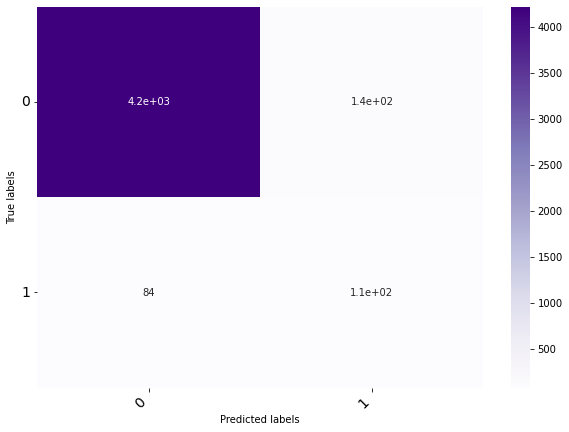

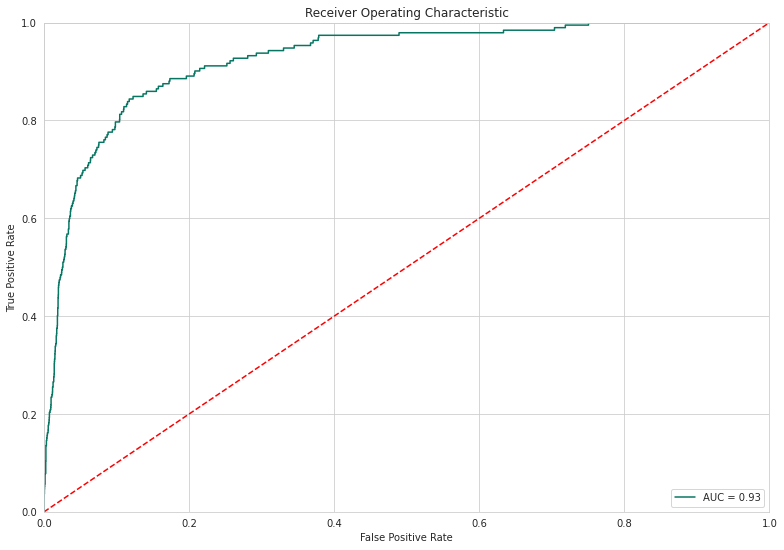

In [38]:
y_label, y, fpr, tpr, roc_auc = print_report(model, testload)